In [1]:
#tweetlerin veritabanından alınması
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import zemberek
import jpype,os
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 
durakwords= set(stopwords.words("turkish"))
import string
import re
from typing import List
from jpype import JClass, JString, getDefaultJVMPath, shutdownJVM, startJVM, java
from scipy import stats
import seaborn as sns
from collections import Counter
from keras.models import Sequential
from keras.layers import Embedding,SpatialDropout1D,LSTM,Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
%matplotlib inline
df=pd.DataFrame()
df=pd.read_csv("C:/Users/user/tweets/tweets2.csv")



In [2]:
#Tweetlerin küçük harfe dönüştürülmesi
df= df.rename(columns = {'hash,content,class': 'tweets'})
df['tweets']=df['tweets'].str.lower()

In [3]:
#tweetlerin son değerlerine göre yeni bir dataframe e yerleştirilmesi
#1 tek,2 spor,eko,pol,mag,sağ,kült
#df[df.tweets.str.endswith('2')]
df['icerik']='icerik'
df['cleantext']='cleantext'
df.loc[df['tweets'].str.endswith('1'),'icerik']="teknoloji"
df.loc[df['tweets'].str.endswith('2'),'icerik']="spor"
df.loc[df['tweets'].str.endswith('3'),'icerik']="ekonomi"
df.loc[df['tweets'].str.endswith('4'),'icerik']="politika"
df.loc[df['tweets'].str.endswith('5'),'icerik']="magazin"
df.loc[df['tweets'].str.endswith('8'),'icerik']="kultur"
df.loc[df['tweets'].str.endswith('7'),'icerik']="saglik"
df.loc[df['tweets'].str.endswith('1'),'label']="1"
df.loc[df['tweets'].str.endswith('2'),'label']="2"
df.loc[df['tweets'].str.endswith('3'),'label']="3"
df.loc[df['tweets'].str.endswith('4'),'label']="4"
df.loc[df['tweets'].str.endswith('5'),'label']="5"
df.loc[df['tweets'].str.endswith('8'),'label']="8"
df.loc[df['tweets'].str.endswith('7'),'label']="7"
pd.to_numeric(df.label)

0        2
1        8
2        4
3        2
4        5
        ..
34995    1
34996    1
34997    1
34998    1
34999    1
Name: label, Length: 35000, dtype: int64

In [4]:
#Zemberek kütüphanesinin kullanılabilmesi için Jpype ile JVM oluşturulması
ZEMBEREK_PATH = r'C:\Users\user\Desktop\dersler\tweets\zemberek-full.jar'
startJVM(getDefaultJVMPath(), '-ea', '-Djava.class.path=%s' % (ZEMBEREK_PATH))
#Morphology kütüphanesini kullanacağımızdan burada oluşturuyoruz
TurkishMorphology = JClass('zemberek.morphology.TurkishMorphology')
morphology = TurkishMorphology.createWithDefaults()


In [5]:
def mentionRemove(text):
    text = re.sub(r'@\w+', '', text)#mentionların çıkartırılması
    return text

In [6]:
def siteRemove(text):
    text = re.sub(r'http.?://[^\s]+[\s]?', '', text)#bağlantıların çıkarılması
    return text

In [7]:
def puncRemove(text):
    text = re.sub('[^a-zığüşiöç\s]', '', text)#özel karakterlerin ve sayıların çıkarılması
    text = re.sub(r"Â", "A", text)#umlautlu karakterlerinn değiştirilmesi
    text = re.sub(r"â", "a", text)
    text = re.sub(r"Î", "I", text)
    text = re.sub(r"î", "ı", text)
    text = re.sub(r"Û", "U", text)
    text = re.sub(r"û", "u", text)

    return text

In [8]:
def removeSw(text):
    text=[w for w in tweet if w.lower() not in durakwords]#stopwordlerin çıkarılması
    return text

In [9]:
def rootFinder(text):
    pos=[]
    textlist=text.split(" ")
    analysis: java.util.ArrayList = ( morphology.analyzeAndDisambiguate(text).bestAnalysis() )
    for i, analysis in enumerate(analysis, start=1):
        f'\nAnalysis {i}: {analysis}',
        f'\nPrimary POS {i}: {analysis.getPos()}' 
        if (str(analysis.getLemmas()[0]) == "UNK"):
            pos.append(textlist[i-1])
        else:     
            pos.append(f'{str(analysis.getLemmas()[0])}')
    return pos


In [10]:
def emojiRemove(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet

In [11]:
#hash kısmının ve sondaki içerik belirteci ve tweet bağlantısının kaldırılması
#utf-16 karakterlerin elenmesi
#kelimelerin ayrıştırılması
#tweet içerisindeki bağlantıların çıkarılması
#tweet içindeki mentionların çıkarılması
p=set(string.punctuation)

def cleaner(text):
    text=text
    text=mentionRemove(text)#mentionların çıkartırılması
    text=siteRemove(text)#bağlantıların çıkarılması
    text=puncRemove(text)#özel karakterlerin ve sayıların çıkarılması
    text=emojiRemove(text)
    text=rootFinder(text)#kelime köklerinin bulunması
    text=removeSw(text)#durak kelimelerin elenmesi
    return text
for x in range(0,len(df)):
    #tweet="ve ya da için baba veya"
    tweet=df.iloc[x,0]
    tweet=mentionRemove(tweet)#mentionların çıkartırılması
    tweet=siteRemove(tweet)#bağlantıların çıkarılması
    #tweet.replace("aracılığıyla","a")
    tweet=puncRemove(tweet)#özel karakterlerin ve sayıların çıkarılması
    tweet=rootFinder(tweet)#kelime köklerinin bulunması
    tweet=removeSw(tweet)#durak kelimelerin elenmesi
    tweet=' '.join(tweet)
    #tweet=cleaner(tweet)
    df.iloc[x,2]=tweet
    pos=[]



In [12]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score,confusion_matrix

In [13]:
print(tf.__version__)
if tf.test.gpu_device_name():
    print("gpu device :{}".format(tf.test.gpu_device_name()))
else:
    print("please install gpu version of tf")

2.3.1
please install gpu version of tf


In [20]:
def counter_words(df):
    count = Counter()
    for i in df:
        for w in i.split():
            count[w] += 1
    return count

In [29]:
c=counter_words(df.cleantext)
num_words = len(c)
max_seq_lenght = 12

In [30]:
tweets=df.cleantext
labels=df.icerik

In [31]:
tokenizer=Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(tweets.tolist())

print(str(tokenizer.texts_to_sequences(["fenerbahçe ben sevgili"])))

[[23, 68, 334]]


In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(tweets.tolist(),labels.tolist(), test_size = 0.3,stratify=labels.tolist(),
                                                    random_state = 44)
print('Train data len: '+ str(len(X_train)))
print('labels: ', Counter(Y_train))
print('test data len: '+ str(len(X_test)))
print('labels: ' ,Counter(Y_test))

Train data len: 24500
labels:  Counter({'teknoloji': 3500, 'spor': 3500, 'politika': 3500, 'kultur': 3500, 'magazin': 3500, 'saglik': 3500, 'ekonomi': 3500})
test data len: 10500
labels:  Counter({'magazin': 1500, 'teknoloji': 1500, 'saglik': 1500, 'politika': 1500, 'kultur': 1500, 'ekonomi': 1500, 'spor': 1500})


In [33]:
X_train=np.array(tokenizer.texts_to_sequences(X_train))
X_test=np.array(tokenizer.texts_to_sequences(X_test))
#Y_train=np.array(tokenizer.texts_to_sequences(Y_train))
X_train=pad_sequences(X_train, padding = 'post',maxlen=max_seq_lenght,truncating="post")
X_test=pad_sequences(X_test, padding = 'post',maxlen=max_seq_lenght,truncating="post")

In [34]:
print(X_train[1])
print(Y_train[:10])

[  122  2777   207 10413   807   477   734   207    54    21     0     0]
['teknoloji', 'spor', 'politika', 'kultur', 'kultur', 'magazin', 'teknoloji', 'spor', 'teknoloji', 'politika']


<function print>

In [35]:
le = LabelEncoder()
train_labels=le.fit_transform(Y_train)
print(train_labels)
train_labels=np.asarray(tf.keras.utils.to_categorical(train_labels))
print(train_labels)
test_labels=le.fit_transform(Y_test)
test_labels=np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

[6 5 3 ... 5 4 6]
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


['ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji']

In [36]:
train_ds=tf.data.Dataset.from_tensor_slices((X_train,train_labels))
test_ds=tf.data.Dataset.from_tensor_slices((X_test,test_labels))

In [37]:
train_labels=np.asarray(tf.keras.utils.to_categorical(le.fit_transform(Y_train)))
train_labels

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [38]:
num_words = len(c)
# Max number of words in each complaint.
max_seq_lenght = 12
# This is fixed.
dim = 100
print(len(c))
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(num_words+1,dim,input_length=max_seq_lenght,embeddings_regularizer=regularizers.l2(0.0001)))
model.add(tf.keras.layers.Conv1D(128,7,activation='relu',kernel_regularizer=regularizers.l2(0.0001),bias_regularizer=regularizers.l2(0.0001)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(7,activation='sigmoid',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.summary()

18507
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 12, 100)           1850800   
_________________________________________________________________
conv1d (Conv1D)              (None, 6, 128)            89728     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 903       
Total params: 1,941,431
Trainable params: 1,941,431
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer='Adam',metrics=["CategoricalAccuracy"])

In [40]:
epochs=10
history=model.fit(train_ds.batch(128),epochs=epochs,validation_data=test_ds.batch(128),verbose=1)

Epoch 1/10


C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


192/192 [==============================] - 3s 18ms/step - loss: 1.4553 - categorical_accuracy: 0.5222 - val_loss: 0.7982 - val_categorical_accuracy: 0.7841
Epoch 2/10
192/192 [==============================] - 3s 17ms/step - loss: 0.6752 - categorical_accuracy: 0.8269 - val_loss: 0.7133 - val_categorical_accuracy: 0.8143
Epoch 3/10
192/192 [==============================] - 3s 17ms/step - loss: 0.5078 - categorical_accuracy: 0.8949 - val_loss: 0.7417 - val_categorical_accuracy: 0.8150
Epoch 4/10
192/192 [==============================] - 3s 17ms/step - loss: 0.4347 - categorical_accuracy: 0.9252 - val_loss: 0.7836 - val_categorical_accuracy: 0.8116
Epoch 5/10
192/192 [==============================] - 3s 17ms/step - loss: 0.3936 - categorical_accuracy: 0.9454 - val_loss: 0.8155 - val_categorical_accuracy: 0.8078
Epoch 6/10
192/192 [==============================] - 3s 17ms/step - loss: 0.3640 - categorical_accuracy: 0.9571 - val_loss: 0.8405 - val_categorical_accuracy: 0.8067
Epoch 7/1

In [1]:
new_complaint = ['erdoğan hastane millet millet oy']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_seq_lenght)
pred = model.predict(padded)
labels = ['ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji']
print(pred, labels[np.argmax(pred)])

NameError: name 'tokenizer' is not defined

In [69]:
preds=model.predict(X_test)
preds=preds.argmax(axis=1)
actual=le.fit_transform(Y_test)
print("accuracy score is",accuracy_score(preds,actual))

accuracy score is 0.8019047619047619


In [70]:
print(classification_report(actual, preds,target_names=['ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji']))

              precision    recall  f1-score   support

     ekonomi       0.77      0.76      0.76      1500
      kultur       0.74      0.74      0.74      1500
     magazin       0.74      0.77      0.75      1500
    politika       0.82      0.83      0.83      1500
      saglik       0.86      0.79      0.82      1500
        spor       0.87      0.89      0.88      1500
   teknoloji       0.82      0.85      0.83      1500

    accuracy                           0.80     10500
   macro avg       0.80      0.80      0.80     10500
weighted avg       0.80      0.80      0.80     10500



2021-01-25 21:51:16,849 - numexpr.utils - INFO
Msg: NumExpr defaulting to 8 threads.



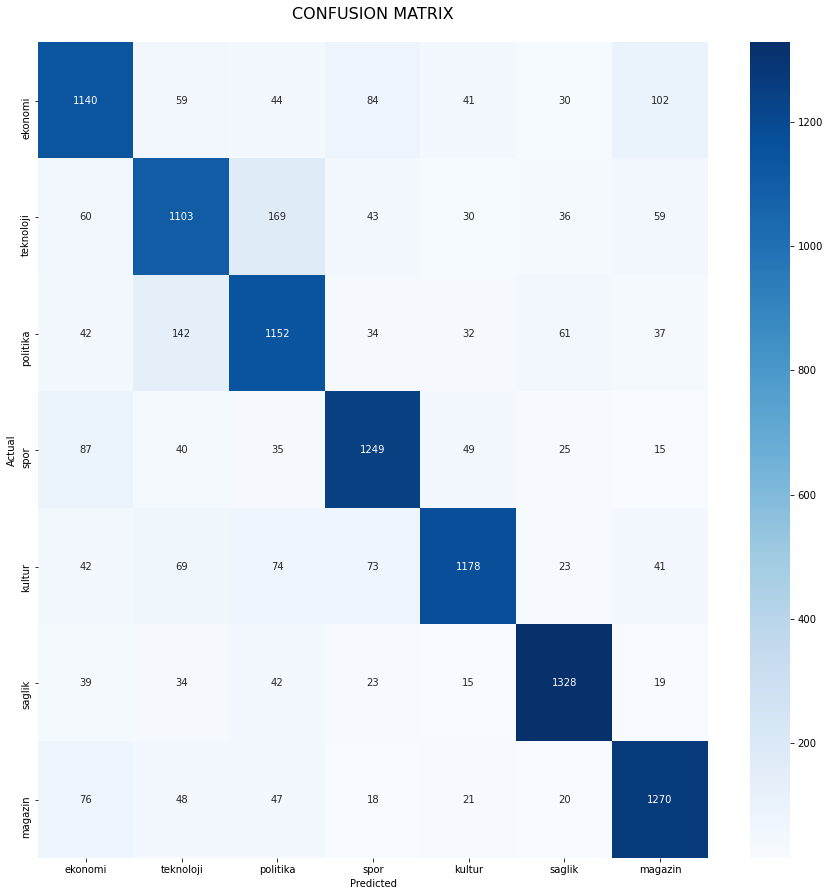

In [71]:
conf_mat = confusion_matrix(actual,preds)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'},
            yticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=16);

In [ ]:
pred=model.predict()